In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pystan
import glob
import pandas as pd
from keplerdata import Dataset
plt.rcParams['figure.figsize'] = [12,10]
from tqdm import tqdm

In [2]:
datadir = '/Users/davies/Projects/ClusterUp/Data/MNLNGC6791-20180307-231444/output/KASOC_Corrected_timeseries/'
sfiles = glob.glob(datadir + '*.dat')
df = pd.read_csv('/Users/davies/Dropbox/K2_seismo_pipes/NGC6791/Data/NGC6791.csv')
df['EPIC'] = df.KIC
df_out = pd.read_csv('/Users/davies/Projects/KeplerGold/output_NGC6791.csv')
df_out['KIC'] = df_out.ID
df = df.merge(df_out, on='KIC', how='inner')

df = df[df.KIC != 2436097]
df = df[df.KIC != 2436593]
df = df[df.KIC != 2436954]
df = df[df.KIC != 2436759]
df = df[df.KIC != 2437496]

df = df[:7**2]
dss = [Dataset(row.EPIC, glob.glob(datadir + 'kplr*' + str(row.EPIC) + '*.dat')[0]) for idx, row in df.iterrows()]
for ds in tqdm(dss):
    ds.power_spectrum(dfN=(0.01, 28800))
    ds.rebin_quick(100)
power = [ds.smoo_power for ds in dss]
freq = dss[0].smoo_freq

100%|██████████| 49/49 [00:22<00:00,  2.14it/s]


In [3]:
data = np.zeros([len(dss[0].smoo_power), len(dss)])
for idx, p in enumerate(power):
    data[:,idx] = p
freq = freq[2:]
data = data[2:, :]

Text(0,0.5,'Rebinned power')

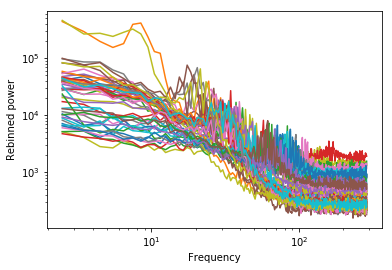

In [4]:
fig, ax = plt.subplots()
for idx, d in enumerate(data[0,:]):
    plt.plot(freq, data[:, idx])
ax.plot(freq, data[:,0])
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('Frequency')
ax.set_ylabel('Rebinned power')

In [5]:
df.loc[df.KIC == 2436593, 'Numax'] = 28.0
numaxs = df.Numax.values
whites = np.median(data[-3:,:], axis=0)
kics = df.KIC.values

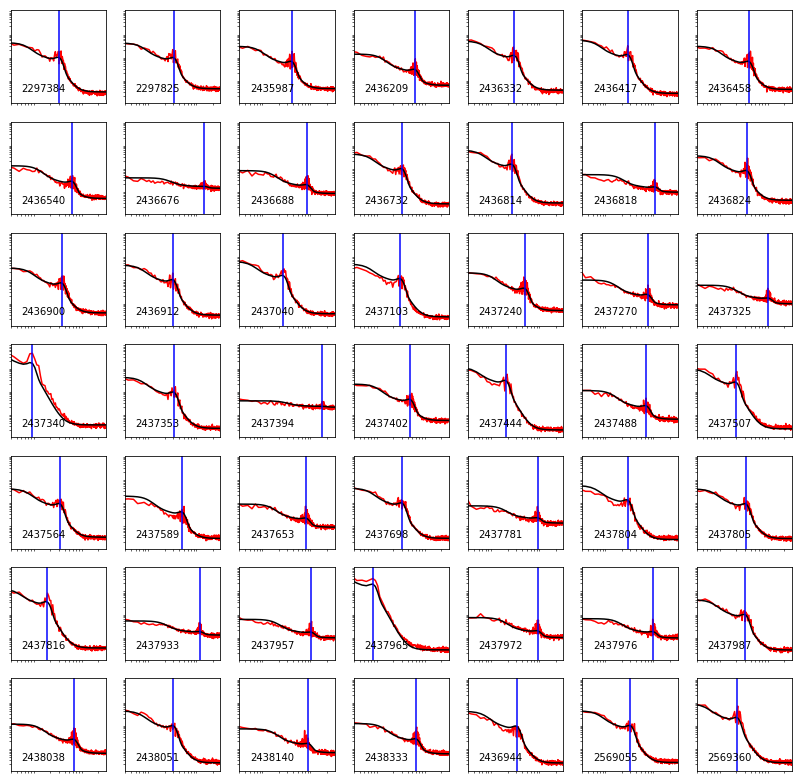

In [26]:
def harvey(f, a, b, c=4.0):
    return 0.9*a**2/b/(1 + (f/b)**c)
def gaussian(f, numax, width, height):
    return height * np.exp(-0.5 * (f - numax)**2 / width**2)
def apod(f, nyq):
    x = f / 2.0 / nyq
    
    return np.sinc(x)**2
def model(f, ak, ae, bk, be, ck, ce, dk, de, numax, wk, we, hk, he, white):
    a = 10**(ak + numax*ae)
    b = 10**(bk + numax*be)
    c = 10**(ck + numax*ce)
    d = 10**(dk + numax*de)
    width = 10**(wk + numax*we)
    height = 10**(hk + numax*he)
    model = (apod(f, 288.8) * (harvey(f, a, b) + harvey(f, c, d) + gaussian(f, 10**numax, width, height))) + 10**white
    return model
ak, ae = 3.4, -0.48
bk, be = -0.43, 0.86
ck, ce = 3.59, -0.59
dk, de = 0.02, 0.96
wk, we = -0.82, 1.03
hk, he = 6.95, -2.18
n = 7
fig, ax = plt.subplots(n,n, figsize=[14, 14])
for i in range(0, n*n):
    x = i // n
    y = i % n
    fit0 = model(freq, 
                 ak, ae, bk, be, 
                 ck, ce, dk, de, np.log10(numaxs[i]), 
                 wk, we, hk, he, 
                 np.log10(whites[i]))
    ax[x, y].plot(freq, data[:,i], 'r-')
    ax[x, y].plot(freq, fit0, 'k-')
    ax[x, y].set_xscale('log')
    ax[x, y].set_yscale('log')
    ax[x, y].set_ylim([1e2, 1e6])
    ax[x, y].set_xlim([3 ,288])
    ax[x, y].axvline(numaxs[i], c='b')
    ax[x, y].set_yticks([])
    ax[x, y].set_xticks([])
    ax[x, y].text(5, 3e2, str(kics[i]))

Text(0,0.5,'Log White Noise')

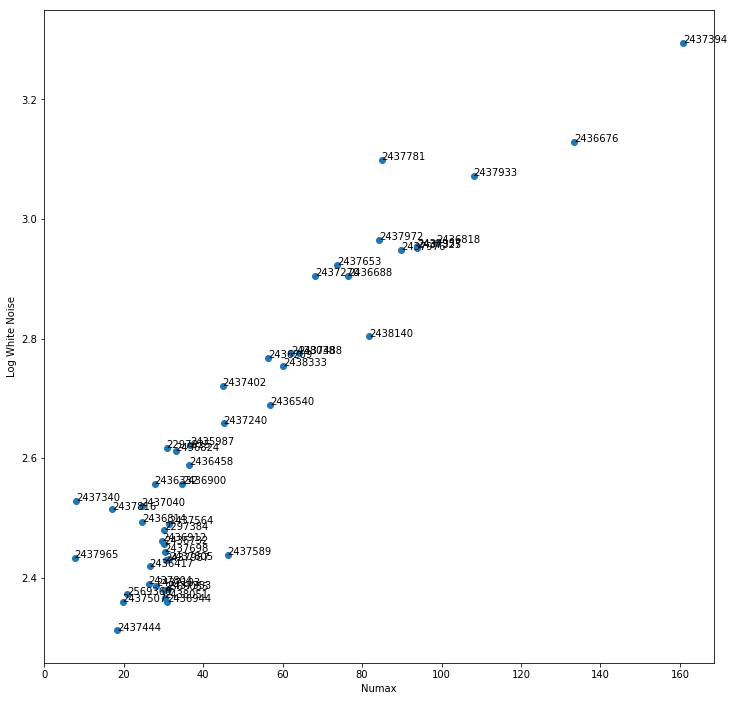

In [7]:
fig, ax = plt.subplots(figsize=[12,12])
ax.scatter(numaxs, np.log10(whites))
for i in range(len(kics)):
    ax.text(numaxs[i], np.log10(whites[i]), str(kics[i]))
ax.set_xlabel('Numax')
ax.set_ylabel('Log White Noise')

The gamma function in stan is parameterised in a way I'm not used to (wiki says the stan way is common in Bayesian stats).  Let's investigate.

${\rm Gamma}(\alpha, \beta) = \frac{\beta^{\alpha}}{\Gamma(\alpha)} x^{\alpha - 1} e^{-\beta x}$.

This parameterisation gives a mean value $\frac{\alpha }{\beta}$ and a variance of $\frac{\alpha}{\beta^{2}}$.  $\alpha$ is called the shape and $\beta$ is called the rate.

$\alpha$ is the same parameter as the shape $k$ in my familiar notation.  The rate $\beta$ is then the recipricol of the scale, i.e., $\theta = \frac{1}{\beta}$.

When fitting a power spectrum the data are the model multiplied by the noise distribution.  If we calculate the data divided by the model we are left with the noise distirbution.  

In [ ]:
code = '''
functions {
    real harvey(real f, real a, real b, real c){
        return 0.9*a^2/b/(1.0 + (f/b)^c);
    }
    real gaussian(real f, real numax, real width, real height){
        return height * exp(-0.5 * (f - numax)^2 / width^2);
    }
    real apod(real f, real nyq){
        real x = 3.14 / 2.0 * f / nyq;
        return (sin(x) / x)^2;
    }
}
data {
    int N;
    int M;
    int dof;
    vector[N] f;
    real p[N, M];
    vector[M] numax;
    vector[M] white;

}
parameters {
    real ae;
    real be;
    real ce;
    real de;
    real<lower = 3.0> ak;
    real bk;
    real<lower = 3.0> ck;
    real dk;
    real wk;
    real we;
    real hk;
    real he; 
}
transformed parameters {
    vector[M] a;
    vector[M] b;
    vector[M] c;
    vector[M] d;
    vector[M] w;
    vector[M] h;
    for (j in 1:M){
        a[j] = 10^((ak + numax[j] * ae));
        b[j] = 10^((bk + (numax[j]) * be));
        c[j] = 10^((ck + (numax[j]) * ce));
        d[j] = 10^((dk + (numax[j]) * de));
        w[j] = 10^((wk + (numax[j]) * we));
        h[j] = 10^((hk + (numax[j]) * he));
    }
}
model {
    real beta[N, M];
    for (j in 1:M){
        for (i in 1:N){
            beta[i, j] = dof / (apod(f[i], 288.8)
                        * (harvey(f[i], a[j], b[j], 4.0)
                        + harvey(f[i], c[j], d[j], 4.0)
                        + gaussian(f[i], 10^numax[j], w[j], h[j]))
                        + 10^white[j]);
        }
        p[1:N, j] ~ gamma(dof, beta[1:N, j]);
    }
    ak ~ normal(3.65, 0.5); // log 10
    ae ~ normal(-0.62, 0.5);
    bk ~ normal(-0.15, 0.5); //log10
    be ~ normal(0.74, 0.5);
    ck ~ normal(3.39, 0.5); // log10
    ce ~ normal(-0.51, 0.5);
    dk ~ normal(0.27, 0.5); //log10
    de ~ normal(0.83, 0.5);
    wk ~ normal(-0.3, 0.5); // log10
    we ~ normal(0.7, 0.5);
    hk ~ normal(7.06, 0.5); // log10
    he ~ normal(-2.11, 0.5);
}
'''
sm = pystan.StanModel(model_code=code, model_name='backfit')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL backfit_1222e3db1fc193826d924d9fb0a784a1 NOW.


In [ ]:
dat = {'N': len(freq),
       'M': len(numaxs),
       'dof': 100,
      'f': freq,
      'p': data,
      'numax': np.log10(numaxs),
      'white': np.log10(whites)}
ak, ae = 3.65, -0.62
bk, be = -0.15, 0.74
ck, ce = 3.39, -0.51
dk, de = 0.27, 0.83
wk, we = -0.3, 0.7
hk, he = 7.06, -2.11
start = [{'ak': ak, 'ae': ae, 'bk': bk, 'be': be, 
          'ck': ck, 'ce': ce, 'dk': dk, 'de': de, 
          'wk': wk, 'we': we, 'hk': hk, 'he': he}]
# Note dof is not actually dof but is in fact the number of bins over which we have smoothed.
fit = sm.sampling(data=dat, iter=1000, chains=1, init=start)

In [ ]:
print(fit)

In [ ]:
fit.plot()

In [ ]:
n = 7
fig, ax = plt.subplots(n,n, figsize=[14, 14])
ak = fit['ak'].mean()
ae = fit['ae'].mean()
bk = fit['bk'].mean()
be = fit['be'].mean()
ck = fit['ck'].mean()
ce = fit['ce'].mean()
dk = fit['dk'].mean()
de = fit['de'].mean()
wk = fit['wk'].mean()
we = fit['we'].mean()
hk = fit['hk'].mean()
he = fit['he'].mean()
numax = np.log10(numaxs)
white = np.log10(whites)
for i in range(0, n*n):
    fit0 = model(freq, ak, ae, bk, be, ck, ce, dk, de, numax[i], wk, we, hk, he, white[i])
    x = i // n
    y = i % n
    ax[x, y].plot(freq, data[:,i], 'r-')
    ax[x, y].plot(freq, fit0, 'k-')
    ax[x, y].set_xscale('log')
    ax[x, y].set_yscale('log')
    ax[x, y].set_ylim([1e2, 1e6])
    ax[x, y].set_xlim([3 ,288])
    ax[x, y].axvline(10**numax[i], c='g', linestyle='--')
    ax[x, y].axvline(numaxs[i], c='b')
    ax[x, y].set_yticks([])
    ax[x, y].set_xticks([])